# Import

In [32]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC, Recall


# Check GPU

In [2]:
import tensorflow as tf

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available:  1


# Load data

In [3]:
# Specify the path to your CSV file
csv_file_path = 'JustRAIGS_Train_labels.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path, delimiter=';')

In [4]:
# Display the DataFrame
print(df[df['Final Label'] == 'RG'].head(20))

          Eye ID Final Label Fellow Eye ID   Age Label G1 Label G2 Label G3  \
34   TRAIN000034          RG           NaN  32.0       RG       RG      NaN   
60   TRAIN000060          RG           NaN  74.0       RG       RG      NaN   
68   TRAIN000068          RG   TRAIN012581  64.0       RG      NRG       RG   
100  TRAIN000100          RG           NaN  77.0       RG      NRG       RG   
106  TRAIN000106          RG   TRAIN014144  81.0       RG       RG      NaN   
122  TRAIN000122          RG   TRAIN044306  72.0        U       RG       RG   
127  TRAIN000127          RG   TRAIN002695  73.0       RG      NRG       RG   
140  TRAIN000140          RG           NaN  73.0       RG       RG      NaN   
188  TRAIN000188          RG   TRAIN035113  78.0      NaN      NaN       RG   
195  TRAIN000195          RG   TRAIN090999  80.0       RG       RG      NaN   
225  TRAIN000225          RG   TRAIN073663  61.0       RG      NRG       RG   
285  TRAIN000285          RG   TRAIN102041  67.0    

In [5]:
df['Eye ID'] = df['Eye ID'] + '.JPG'

In [6]:
df[df['Final Label'] == 'RG']['Eye ID']

34        TRAIN000034.JPG
60        TRAIN000060.JPG
68        TRAIN000068.JPG
100       TRAIN000100.JPG
106       TRAIN000106.JPG
               ...       
101296    TRAIN101315.JPG
101339    TRAIN101358.JPG
101343    TRAIN101362.JPG
101348    TRAIN101367.JPG
101349    TRAIN101368.JPG
Name: Eye ID, Length: 3270, dtype: object

In [7]:
# RG= '1'
# NRG= '0'

RG = 'RG'
NRG = 'NRG'

# df.loc[df['Final Label'] == 'RG', 'Final Label'] = RG 
# df.loc[df['Final Label'] == 'NRG', 'Final Label'] = NRG
df['Final Label'].value_counts()

Final Label
NRG    98153
RG      3270
Name: count, dtype: int64

In [8]:
df = df[['Eye ID', 'Final Label']]
df['Final Label'] = df['Final Label'].astype(str)
df

,Eye ID,Final Label
0,TRAIN000000.JPG,NRG
1,TRAIN000001.JPG,NRG
2,TRAIN000002.JPG,NRG
3,TRAIN000003.JPG,NRG
4,TRAIN000004.JPG,NRG
...,...,...
101418,TRAIN101437.JPG,NRG
101419,TRAIN101438.JPG,NRG
101420,TRAIN101439.JPG,NRG
101421,TRAIN101440.JPG,NRG


In [9]:
# check already ROI generated
import os

filenames = set(os.listdir('ROI'))
roi_generated = df[df['Eye ID'].isin(filenames)].copy()
roi_generated['Final Label'].value_counts()

Final Label
NRG    3270
RG     3270
Name: count, dtype: int64

# Count Class

# Split 

In [10]:
train_rg = roi_generated[roi_generated['Final Label'] == RG].sample(n=2000, random_state=42)
train_nrg = roi_generated[roi_generated['Final Label'] == NRG].sample(n=2000, random_state=42)

# Extract index labels of sampled rows
sampled_index = pd.concat([train_rg, train_nrg]).index

# Remove sampled rows from the original DataFrame
cleaned_df = roi_generated.drop(index=sampled_index)

train_df = pd.concat([train_nrg, train_rg])
train_df['type']= 'TRAIN'

In [11]:
val_rg = cleaned_df[cleaned_df['Final Label'] == RG].sample(n=500, random_state=42)
val_nrg = cleaned_df[cleaned_df['Final Label'] == NRG].sample(n=500, random_state=42)

# Extract index labels of sampled rows
sampled_index = pd.concat([val_rg, val_nrg]).index

# Remove sampled rows from the original DataFrame
cleaned_df = cleaned_df.drop(index=sampled_index)
val_df = pd.concat([val_nrg, val_rg])
val_df['type']= 'VAL'

In [12]:
train_df['Final Label'].value_counts()

Final Label
NRG    2000
RG     2000
Name: count, dtype: int64

In [13]:
val_df['Final Label'].value_counts()

Final Label
NRG    500
RG     500
Name: count, dtype: int64

In [14]:
test_rg = cleaned_df[cleaned_df['Final Label'] == RG]
test_nrg = cleaned_df[cleaned_df['Final Label'] == NRG].sample(n=770, random_state=42)
test_df = pd.concat([test_nrg, test_rg])
test_df['type'] = 'TEST'

In [15]:
#Simpan data yang terpilih training val dan test saja
# Concatenating DataFrames
# combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)  # ignore_index=True resets the index

# Exporting combined DataFrame to a CSV file
# combined_df.to_csv('combined_data.csv', index=False)

# Load data into generator

In [16]:
aug_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values between 0 and 1
    rotation_range=20,  # Randomly rotate images by up to 20 degrees
    width_shift_range=0.1,  # Randomly shift images horizontally by up to 10%
    height_shift_range=0.1,  # Randomly shift images vertically by up to 10%
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=False,  # Don't flip images vertically
    fill_mode='nearest'  # Strategy for filling in newly created pixels
)

# Define other parameters for data loading
# target_size = (512, 512)
target_size = (256, 256)

# Define the path to your image directory
image_folder = 'ROI'
# image_folder = 'JustRAIGS_Train'

# Create an ImageDataGenerator instance for your dataset
train_image_generator = aug_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_folder,
    x_col='Eye ID',
    y_col='Final Label',
    target_size=target_size,
    class_mode='categorical'
)

datagen = ImageDataGenerator(rescale=1./255) 

val_image_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_folder,
    x_col='Eye ID',
    y_col='Final Label',
    target_size=target_size,
    class_mode='categorical'
)

test_image_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_folder,
    x_col='Eye ID',
    y_col='Final Label',
    target_size=target_size,
    class_mode='categorical'
)

Found 4000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1540 validated image filenames belonging to 2 classes.


# Create Model

## V1

Own trial

In [17]:
# Define the model
model_name = 'v1'
def createV1Model():
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(3, (5, 5), activation='relu', input_shape=(512, 512, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(48, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(96, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten layer to transition from convolutional to fully connected layers
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='softmax'))  # Output layer with sigmoid activation for binary classification

    return model

## V2

https://journals.lww.com/ijo/fulltext/2021/10000/identification_of_glaucoma_from_fundus_images.31.aspx

In [18]:
# Define the model
model_name = 'v2'

def createV2Model():
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
    # model.add(BatchNormalization())
    # model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    # model.add(BatchNormalization())
    # model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    # model.add(BatchNormalization())
    # model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Flatten layer to transition from convolutional to fully connected layers
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1023, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))  # Output layer with sigmoid activation for binary classification

    return model


## V3 
https://www.mdpi.com/2079-9292/11/1/26

In [19]:
# Define the model
def createV3Model():
    model_name = 'v3'
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(20, (5, 5), activation='relu', input_shape=(256, 256, 3)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(40, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten layer to transition from convolutional to fully connected layers
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1023, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))  # Output layer with sigmoid activation for binary classification

    return model

## V4
VGG Based
https://ieeexplore.ieee.org/abstract/document/9344603/figures#figures


Double BN
Epoch 8/10
125/125 [==============================] - 65s 499ms/step - loss: 0.4171 - accuracy: 0.8135 - val_loss: 0.4521 - val_accuracy: 0.8190
Epoch 9/10
125/125 [==============================] - 64s 490ms/step - loss: 0.4166 - accuracy: 0.8083 - val_loss: 0.4217 - val_accuracy: 0.8220
Epoch 10/10
125/125 [==============================] - 65s 489ms/step - loss: 0.4213 - accuracy: 0.8073 - val_loss: 0.5034 - val_accuracy: 0.7900

In [20]:
# check vggg structure

# Load pre-trained VGG model
# vgg16 = VGG16(weights='imagenet', include_top=False)

# Print the list of layers in the vgg16
# for i, layer in enumerate(vgg16.layers[:-4]):
#     print("Layer {}: {}".format(i, layer.name))

In [26]:
model_name = 'v4'

def createV4Model():
    base_model = VGG16(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=(256, 256, 3),
        include_top=False)

    # Freeze all layers except the last convolutional block
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(BatchNormalization())
    model.add(Flatten())
    # model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))

    return model

# Compile

In [22]:
# Compile the model
def compile_model(model):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', AUC(name='auc'), Recall(name='recall')])

# Train

In [23]:
def start_train(model, epoch):
    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    history = model.fit(x=train_image_generator,
            epochs=epoch,
            workers=16,
            batch_size=64,
            validation_data=val_image_generator,
            callbacks=[early_stopping]
    )

    return history

In [24]:
def save_model_and_history(model, history, model_name):
    model.save(f'./weights/{model_name}')

    # Save history
    history_df = pd.DataFrame(history.history)

    # Save to CSV
    history_df.to_csv(f'./weights/{model_name}/training_history.csv', index=False)

    return history_df

In [27]:
model = createV4Model()
compile_model(model)
history = start_train(model, 200)
history_df = save_model_and_history(model, history, 'vgg2densebn_200epoch_not_denoised')

Epoch 1/200
125/125 [==============================] - 47s 292ms/step - loss: 0.6828 - accuracy: 0.6298 - auc: 0.6716 - recall: 0.6298 - val_loss: 1.2653 - val_accuracy: 0.6030 - val_auc: 0.6633 - val_recall: 0.6030
Epoch 2/200
125/125 [==============================] - 22s 173ms/step - loss: 0.5480 - accuracy: 0.7207 - auc: 0.7990 - recall: 0.7207 - val_loss: 1.6747 - val_accuracy: 0.5100 - val_auc: 0.6527 - val_recall: 0.5100
Epoch 3/200
125/125 [==============================] - 22s 171ms/step - loss: 0.5121 - accuracy: 0.7347 - auc: 0.8240 - recall: 0.7347 - val_loss: 3.8459 - val_accuracy: 0.5000 - val_auc: 0.5025 - val_recall: 0.5000
Epoch 4/200
125/125 [==============================] - 22s 172ms/step - loss: 0.4889 - accuracy: 0.7545 - auc: 0.8398 - recall: 0.7545 - val_loss: 1.2176 - val_accuracy: 0.5730 - val_auc: 0.6829 - val_recall: 0.5730
Epoch 5/200
125/125 [==============================] - 22s 172ms/step - loss: 0.4764 - accuracy: 0.7610 - auc: 0.8510 - recall: 0.7610 -

INFO:tensorflow:Assets written to: ./weights/vgg2densebn_200epoch_not_denoised\assets


INFO:tensorflow:Assets written to: ./weights/vgg2densebn_200epoch_not_denoised\assets


In [47]:
model = createV2Model()
compile_model(model)
history = start_train(model, 200)
history_df = save_model_and_history(model, history, '13layer_200epoch_not_denoised_2')

Epoch 1/200
125/125 [==============================] - 33s 252ms/step - loss: 3.0512 - accuracy: 0.5240 - auc: 0.5298 - recall: 0.5240 - val_loss: 0.9225 - val_accuracy: 0.5510 - val_auc: 0.5522 - val_recall: 0.5510
Epoch 2/200
125/125 [==============================] - 31s 242ms/step - loss: 0.9696 - accuracy: 0.5428 - auc: 0.5529 - recall: 0.5428 - val_loss: 0.7168 - val_accuracy: 0.5150 - val_auc: 0.5100 - val_recall: 0.5150
Epoch 3/200
125/125 [==============================] - 31s 241ms/step - loss: 0.7731 - accuracy: 0.5760 - auc: 0.5960 - recall: 0.5760 - val_loss: 0.6593 - val_accuracy: 0.5990 - val_auc: 0.6518 - val_recall: 0.5990
Epoch 4/200
125/125 [==============================] - 31s 240ms/step - loss: 0.6961 - accuracy: 0.5965 - auc: 0.6278 - recall: 0.5965 - val_loss: 0.7200 - val_accuracy: 0.5310 - val_auc: 0.5711 - val_recall: 0.5310
Epoch 5/200
125/125 [==============================] - 31s 243ms/step - loss: 0.6852 - accuracy: 0.6148 - auc: 0.6441 - recall: 0.6148 -

INFO:tensorflow:Assets written to: ./weights/13layer_200epoch_not_denoised_2\assets


INFO:tensorflow:Assets written to: ./weights/13layer_200epoch_not_denoised_2\assets


# Load Saved Weight

In [30]:
def load_weight_and_history(model_name):
    model = load_model(f'./weights/{model_name}')
    history_df = pd.read_csv(f'./weights/{model_name}/training_history.csv')

    return (model, history_df)

In [51]:
# model, history_df = load_weight_and_history('vgg2densebn_200epoch_not_denoised')
model, history_df = load_weight_and_history('13layer_200epoch_not_denoised_2')

# Plot

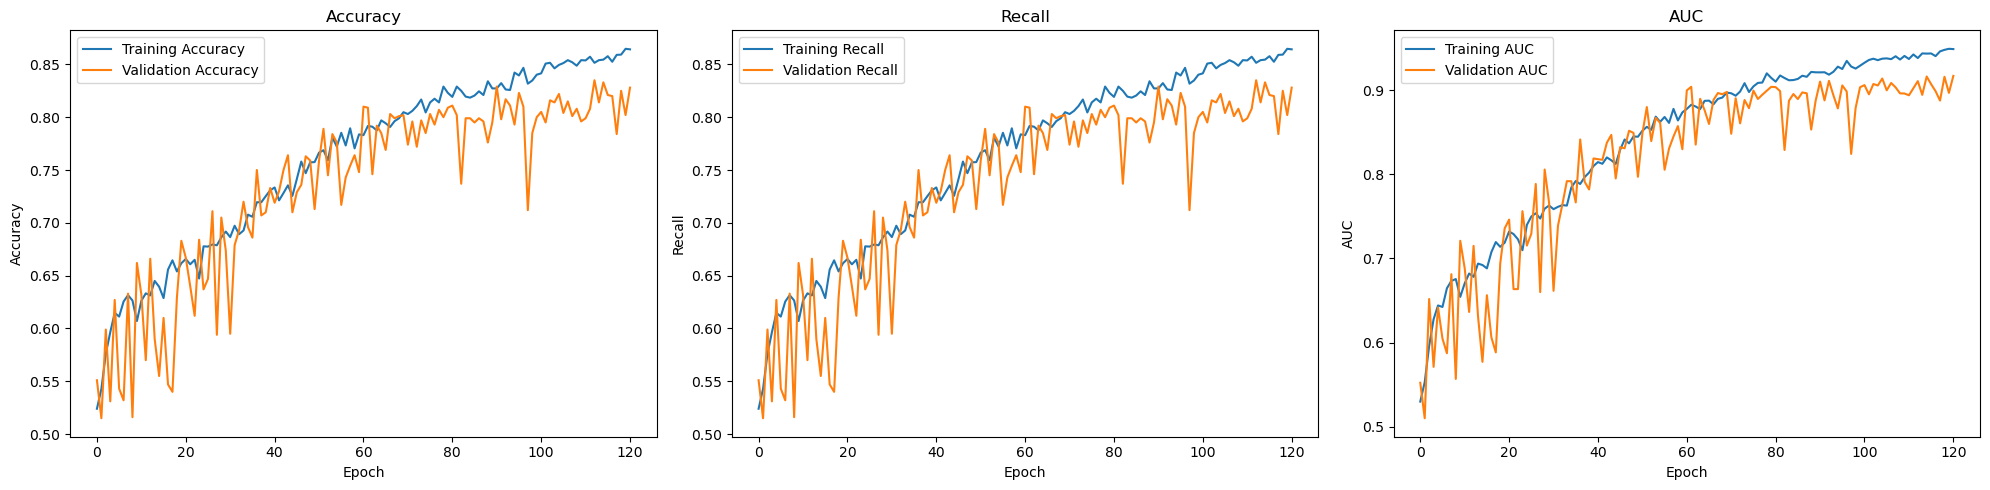

In [52]:
import matplotlib.pyplot as plt

# Plot training & validation metrics
plt.figure(figsize=(20, 5))

# Plot accuracy
plt.subplot(1, 3, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot recall
plt.subplot(1, 3, 2)
plt.plot(history_df['recall'], label='Training Recall')
plt.plot(history_df['val_recall'], label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# Plot AUC
plt.subplot(1, 3, 3)
plt.plot(history_df['auc'], label='Training AUC')
plt.plot(history_df['val_auc'], label='Validation AUC')
plt.title('AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


# Test

In [53]:
loss, accuracy, auc, recall= model.evaluate(test_image_generator)

49/49 [==============================] - 32s 651ms/step - loss: 0.3877 - accuracy: 0.8078 - auc: 0.9062 - recall: 0.8078


In [42]:
print(loss, accuracy, auc, recall)

0.4268474578857422 0.7876623272895813 0.8812773823738098 0.7876623272895813
